In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

import os
import sys
import random

from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('..'))
abs_path = "/content/drive/MyDrive/atml"
sys.path.append(abs_path+"/models")
sys.path.append(abs_path+"/train")
sys.path.append(abs_path+"/datasets")

from datasets import load_dsprites, CustomDSpritesDataset, train_test_random_split
from beta_vae import BetaVAEDSprites
from entanglement_metric import compute_mig

# Fix seed 
torch.manual_seed(2)
random.seed(2)
np.random.seed(2)

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [7]:
class NoiseGeneratorNet(nn.Module):
    def __init__(self, max_norm=1):
        super(NoiseGeneratorNet, self).__init__()

        self.max_norm = max_norm
        self.net = nn.Sequential(
            nn.Linear(5, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, 64 * 64),
        )

    def forward(self, x):
        out = self.net(x)
        out = out.view(-1, 64, 64)
        out = torch.clamp(out, min=-self.max_norm, max=self.max_norm)

        return out

In [8]:
def get_new_entangle_distangle_model_and_optimizer():
    model = BetaVAEDSprites()
    for param in model.encoder.parameters():
        param.requires_grad = False
    model_optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

    return model, model_optimizer

In [9]:
def save_model(epoch, model, optimizer, path):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
          }, path)

In [10]:
def load_models_and_optimizers(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']  

    return epoch, model, optimizer

In [11]:
def test(dataset, test_loader, device,
         noisenet, noisenet_optimizer,
         ent_model, ent_optimizer,
         dis_model, dis_optimizer):

    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.MSELoss()

    noisenet = noisenet.to(device)
    ent_model = ent_model.to(device)
    dis_model = dis_model.to(device)

    noisenet.eval()
    ent_model.eval()
    dis_model.eval()

    ent_losses = []
    dis_losses = []
    noisenet_losses = []
    total_samples = 0 

    with torch.no_grad():
        for lt_mx in tqdm(test_loader, leave=False):
            indices = dataset.latent_to_index(lt_mx)
            lt_values = dataset.retrieve_latent_values(lt_mx.numpy())[:, 1:].to(device)

            x = dataset[indices].to(device).type(torch.float)
            noise = noisenet(lt_values.type(torch.float)).to(device)
            x_mod = torch.clamp(x + epsilon * noise, min=0, max=1)

            ent_recon, _, _ = ent_model(x)
            dis_recon, _, _ = dis_model(x)

            ent_recon = ent_recon.view(-1, 64, 64)
            dis_recon = dis_recon.view(-1, 64, 64)

            ent_recon_loss = criterion(ent_recon, x_mod.detach())
            dis_recon_loss = criterion(dis_recon, x_mod.detach())
            noisenet_loss = ent_recon_loss - dis_recon_loss

            ent_losses.append(ent_recon_loss * len(lt_mx))
            dis_losses.append(dis_recon_loss * len(lt_mx))
            noisenet_losses.append(noisenet_loss * len(lt_mx))
            total_samples += len(lt_mx)

        avg_ent_loss = sum(ent_losses) / total_samples
        avg_dis_loss = sum(dis_losses) / total_samples
        avg_noisenet_loss = sum(noisenet_losses) / total_samples

        print(f"Val | Ent Rec Loss: {avg_ent_loss} | Dis Rec Loss: {avg_dis_loss} | Noisenet Loss: {avg_noisenet_loss}")

In [12]:
def train(epochs, epsilon, dataset, 
          train_loader, test_loader, load_previous, device,
          noisenet, noisenet_optimizer, noisenet_path,
          ent_model, ent_optimizer, entangled_model_path,
          dis_model, dis_optimizer, disentangled_model_path):
  
    if load_previous:
        epoch, noisenet, noisenet_optimizer = load_models_and_optimizers(noisenet, noisenet_optimizer, noisenet_path)
        _, ent_model, ent_optimizer = load_models_and_optimizers(ent_model, ent_optimizer, entangled_model_path)
        _, dis_model, dis_optimizer = load_models_and_optimizers(dis_model, dis_optimizer, disentangled_model_path)

    # criterion = nn.BCEWithLogitsLoss()
    criterion = nn.MSELoss()

    noisenet = noisenet.to(device)
    ent_model = ent_model.to(device)
    dis_model = dis_model.to(device)
    
    noisenet.train()
    ent_model.train()
    dis_model.train()

    for i in tqdm(range(epochs)):

        ent_losses = []
        dis_losses = []
        noisenet_losses = []
        total_samples = 0 

        for lt_mx in tqdm(train_loader, leave=False):
            noisenet_optimizer.zero_grad()
            ent_optimizer.zero_grad()
            dis_optimizer.zero_grad()

            indices = dataset.latent_to_index(lt_mx)
            lt_values = dataset.retrieve_latent_values(lt_mx.numpy())[:, 1:].to(device)

            x = dataset[indices].to(device).type(torch.float)
            noise = noisenet(lt_values.type(torch.float)).to(device)
            x_mod = torch.clamp(x + epsilon * noise, min=0, max=1)

            ent_recon, _, _ = ent_model(x)
            dis_recon, _, _ = dis_model(x)

            ent_recon = ent_recon.view(-1, 64, 64)
            dis_recon = dis_recon.view(-1, 64, 64)

            ent_recon_loss = criterion(ent_recon, x_mod.detach())
            dis_recon_loss = criterion(dis_recon, x_mod.detach())
    
            ent_recon_loss.backward()
            dis_recon_loss.backward()

            noisenet_loss = criterion(ent_recon.detach(), x_mod) - criterion(dis_recon.detach(), x_mod)
            noisenet_loss.backward()
            
            noisenet_optimizer.step()
            ent_optimizer.step()
            dis_optimizer.step()
            
            ent_losses.append(ent_recon_loss * len(lt_mx))
            dis_losses.append(dis_recon_loss * len(lt_mx))
            noisenet_losses.append(noisenet_loss * len(lt_mx))
            total_samples += len(lt_mx)

        avg_ent_loss = sum(ent_losses) / total_samples
        avg_dis_loss = sum(dis_losses) / total_samples
        avg_noisenet_loss = sum(noisenet_losses) / total_samples

        print(f"Epoch: {i+1} | Ent Rec Loss: {avg_ent_loss} | Dis Rec Loss: {avg_dis_loss} | Noisenet Loss: {avg_noisenet_loss}")

        if i % 10 == 9:
            test(dataset, test_loader, device,
                 noisenet, noisenet_optimizer,
                 ent_model, ent_optimizer, dis_model, dis_optimizer)
            save_model(epoch + i + 1, noisenet, noisenet_optimizer, noisenet_path)
            save_model(epoch + i + 1, ent_model, ent_optimizer, entangled_model_path)
            save_model(epoch + i + 1, dis_model, dis_optimizer, disentangled_model_path)
            


In [13]:
# Define paths
dataset_path = abs_path + "/datasets/dsprites.npz"
noisenet_path = abs_path + '/experiments/trained_models/noise_net.pth.tar'
entangled_model_path = abs_path + '/experiments/trained_models/entangled_model.pth.tar'
disentangled_model_path = abs_path + '/experiments/trained_models/disentangled_model.pth.tar'

In [14]:
## Prepare dataset

dataset = CustomDSpritesDataset(load_dsprites(dataset_path, False))

latent_matrix = dataset.sample_latent(len(dataset))
# sample_latent_values = dataset.retrieve_latent_values(latent_matrix)[:, 1:]

data_train, data_test = train_test_random_split(latent_matrix, 0.8)

batch_size = 128
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [15]:
# Define model and optimizers
noisenet = NoiseGeneratorNet()
noisenet_optimizer = optim.Adam(noisenet.parameters(), lr=3e-4)

ent_model, ent_optimizer = get_new_entangle_distangle_model_and_optimizer()
dis_model, dis_optimizer = get_new_entangle_distangle_model_and_optimizer()

In [ ]:
# epoch = 0

# temp_path = abs_path + '/experiments/trained_models/betavae_models/betavae_beta1_e50_alldata_n.pth.tar'
# checkpoint = torch.load(temp_path)
# ent_model.load_state_dict(checkpoint['state_dict'])
# save_model(epoch, ent_model, ent_optimizer, entangled_model_path)

# temp_path = abs_path + '/experiments/trained_models/betavae_models/betavae_beta4_e50_alldata_n.pth.tar'
# checkpoint = torch.load(temp_path)
# dis_model.load_state_dict(checkpoint['state_dict'])
# save_model(epoch, dis_model, dis_optimizer, disentangled_model_path)

# save_model(epoch, noisenet, noisenet_optimizer, noisenet_path)

# del checkpoint
# del temp_path
# del epoch

In [ ]:
# Define hyperparameters
epochs = 40
load_previous = True
epsilon = .1

In [ ]:
# train(epochs, epsilon, dataset, 
#       train_loader, test_loader, load_previous, device,
#       noisenet, noisenet_optimizer, noisenet_path,
#       ent_model, ent_optimizer, entangled_model_path,
#       dis_model, dis_optimizer, disentangled_model_path)

Epoch: 1 | Ent Rec Loss: 0.0073110503144562244 | Dis Rec Loss: 0.007301248610019684 | Noisenet Loss: 9.803812645259313e-06


Epoch: 2 | Ent Rec Loss: 0.007105094846338034 | Dis Rec Loss: 0.007261352613568306 | Noisenet Loss: -0.0001562540710438043


Epoch: 3 | Ent Rec Loss: 0.006967267487198114 | Dis Rec Loss: 0.007239359896630049 | Noisenet Loss: -0.00027208394021727145


Epoch: 4 | Ent Rec Loss: 0.0068428548984229565 | Dis Rec Loss: 0.007184199057519436 | Noisenet Loss: -0.0003413369122426957


Epoch: 5 | Ent Rec Loss: 0.006712187547236681 | Dis Rec Loss: 0.0071209198795259 | Noisenet Loss: -0.00040873829857446253


Epoch: 6 | Ent Rec Loss: 0.006617887876927853 | Dis Rec Loss: 0.006996151525527239 | Noisenet Loss: -0.00037826623884029686


Epoch: 7 | Ent Rec Loss: 0.006522587966173887 | Dis Rec Loss: 0.0069513339549303055 | Noisenet Loss: -0.00042874430073425174


Epoch: 8 | Ent Rec Loss: 0.006422402337193489 | Dis Rec Loss: 0.006907210685312748 | Noisenet Loss: -0.000484801217680797


Epoch: 9 | Ent Rec Loss: 0.006344745401293039 | Dis Rec Loss: 0.00685034180060029 | Noisenet Loss: -0.0005055970977991819


Epoch: 10 | Ent Rec Loss: 0.006306292489171028 | Dis Rec Loss: 0.006833733059465885 | Noisenet Loss: -0.0005274289287626743


Val | Ent Rec Loss: 0.006209347862750292 | Dis Rec Loss: 0.006782449781894684 | Noisenet Loss: -0.0005730966222472489


Epoch: 11 | Ent Rec Loss: 0.006237597204744816 | Dis Rec Loss: 0.0067748394794762135 | Noisenet Loss: -0.0005372408777475357


Epoch: 12 | Ent Rec Loss: 0.006183235440403223 | Dis Rec Loss: 0.006743579637259245 | Noisenet Loss: -0.0005603388999588788


Epoch: 13 | Ent Rec Loss: 0.006135563366115093 | Dis Rec Loss: 0.006701616104692221 | Noisenet Loss: -0.0005660506431013346


Epoch: 14 | Ent Rec Loss: 0.006099853664636612 | Dis Rec Loss: 0.0066726855002343655 | Noisenet Loss: -0.0005728397518396378


Epoch: 15 | Ent Rec Loss: 0.0060453652404248714 | Dis Rec Loss: 0.0066415355540812016 | Noisenet Loss: -0.000596167694311589


Epoch: 16 | Ent Rec Loss: 0.005989146884530783 | Dis Rec Loss: 0.006601452361792326 | Noisenet Loss: -0.0006122958147898316


Epoch: 17 | Ent Rec Loss: 0.0059371995739638805 | Dis Rec Loss: 0.0065672616474330425 | Noisenet Loss: -0.0006300599197857082


Epoch: 18 | Ent Rec Loss: 0.005887583829462528 | Dis Rec Loss: 0.00653968146070838 | Noisenet Loss: -0.0006520995520986617


Epoch: 19 | Ent Rec Loss: 0.005833357106894255 | Dis Rec Loss: 0.006512368563562632 | Noisenet Loss: -0.0006790011539123952


Epoch: 20 | Ent Rec Loss: 0.005818645935505629 | Dis Rec Loss: 0.0064825136214494705 | Noisenet Loss: -0.000663856859318912


Val | Ent Rec Loss: 0.00578296696767211 | Dis Rec Loss: 0.006479367613792419 | Noisenet Loss: -0.0006964022759348154


Epoch: 21 | Ent Rec Loss: 0.0057990155182778835 | Dis Rec Loss: 0.006456618197262287 | Noisenet Loss: -0.0006575938314199448


Epoch: 22 | Ent Rec Loss: 0.005759971681982279 | Dis Rec Loss: 0.006436330731958151 | Noisenet Loss: -0.0006763539859093726


Epoch: 23 | Ent Rec Loss: 0.005737966392189264 | Dis Rec Loss: 0.006421313621103764 | Noisenet Loss: -0.0006833482766523957


Epoch: 24 | Ent Rec Loss: 0.005709453951567411 | Dis Rec Loss: 0.0063919564709067345 | Noisenet Loss: -0.000682501180563122


Epoch: 25 | Ent Rec Loss: 0.005671150982379913 | Dis Rec Loss: 0.006374332122504711 | Noisenet Loss: -0.0007031840505078435


Epoch: 26 | Ent Rec Loss: 0.005647602025419474 | Dis Rec Loss: 0.006361295003443956 | Noisenet Loss: -0.0007136727799661458


Epoch: 27 | Ent Rec Loss: 0.005614572204649448 | Dis Rec Loss: 0.0063568102195858955 | Noisenet Loss: -0.0007422521593980491


Epoch: 28 | Ent Rec Loss: 0.005596103612333536 | Dis Rec Loss: 0.006338420324027538 | Noisenet Loss: -0.0007423146744258702


Epoch: 29 | Ent Rec Loss: 0.005571966990828514 | Dis Rec Loss: 0.0063263350166380405 | Noisenet Loss: -0.0007543773972429335


Epoch: 30 | Ent Rec Loss: 0.005552801303565502 | Dis Rec Loss: 0.006317824590951204 | Noisenet Loss: -0.0007650154875591397


Val | Ent Rec Loss: 0.005614675581455231 | Dis Rec Loss: 0.006380828563123941 | Noisenet Loss: -0.0007661493145860732


Epoch: 31 | Ent Rec Loss: 0.0055359648540616035 | Dis Rec Loss: 0.006300142966210842 | Noisenet Loss: -0.0007641644333489239


Epoch: 32 | Ent Rec Loss: 0.005508649628609419 | Dis Rec Loss: 0.006282063666731119 | Noisenet Loss: -0.0007734228856861591


Epoch: 33 | Ent Rec Loss: 0.005501129664480686 | Dis Rec Loss: 0.006280199158936739 | Noisenet Loss: -0.0007790729869157076


Epoch: 34 | Ent Rec Loss: 0.00549310352653265 | Dis Rec Loss: 0.00626861909404397 | Noisenet Loss: -0.0007755146361887455


Epoch: 35 | Ent Rec Loss: 0.0054908134043216705 | Dis Rec Loss: 0.006257014814764261 | Noisenet Loss: -0.0007661897107027471


Epoch: 36 | Ent Rec Loss: 0.005467480514198542 | Dis Rec Loss: 0.00625365087762475 | Noisenet Loss: -0.0007861868944019079


Epoch: 37 | Ent Rec Loss: 0.005440548527985811 | Dis Rec Loss: 0.006245735101401806 | Noisenet Loss: -0.000805180286988616


Epoch: 38 | Ent Rec Loss: 0.005430289544165134 | Dis Rec Loss: 0.006244602147489786 | Noisenet Loss: -0.000814306375104934


Epoch: 39 | Ent Rec Loss: 0.0054105306044220924 | Dis Rec Loss: 0.0062238299287855625 | Noisenet Loss: -0.0008132989751175046


Epoch: 40 | Ent Rec Loss: 0.005403561983257532 | Dis Rec Loss: 0.006203785538673401 | Noisenet Loss: -0.0008002105168998241


Val | Ent Rec Loss: 0.005425790790468454 | Dis Rec Loss: 0.006344699300825596 | Noisenet Loss: -0.0009189089760184288



In [ ]:
# _, ent_model, ent_optimizer = load_models_and_optimizers(ent_model, ent_optimizer, entangled_model_path)
# for params in ent_model.decoder.parameters():
#     print(params)

In [ ]:
# _, dis_model, dis_optimizer = load_models_and_optimizers(dis_model, dis_optimizer, disentangled_model_path)
# for params in dis_model.decoder.parameters():
#     print(params)

In [16]:
_, noisenet, noisenet_optimizer = load_models_and_optimizers(noisenet, noisenet_optimizer, noisenet_path)
_, ent_model, ent_optimizer = load_models_and_optimizers(ent_model, ent_optimizer, entangled_model_path)
_, dis_model, dis_optimizer = load_models_and_optimizers(dis_model, dis_optimizer, disentangled_model_path)

noisenet = noisenet.to(device)
noisenet.eval()

NoiseGeneratorNet(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [17]:
torch.save(noisenet.state_dict(), abs_path + "/datasets/noisenet.pth")

In [ ]:
lt_mx = torch.from_numpy(latent_matrix[200].reshape(1, -1))

indices = dataset.latent_to_index(lt_mx)
lt_values = dataset.retrieve_latent_values(lt_mx.numpy())[:, 1:].to(device)

x = dataset[indices].to(device).type(torch.float)
noise = noisenet(lt_values.type(torch.float)).to(device)
x_mod = torch.clamp(x + epsilon * noise, min=0, max=1)

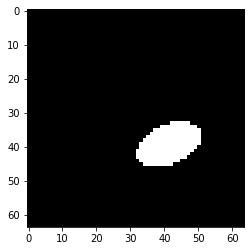

In [ ]:
plt.imshow(x.cpu().detach().numpy().squeeze(0), cmap='gray')

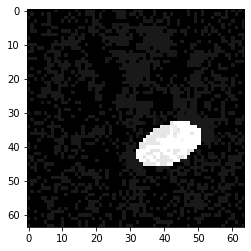

In [ ]:
plt.imshow(x_mod.cpu().detach().numpy().squeeze(0), cmap='gray')

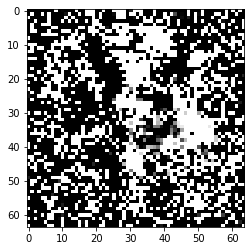

In [ ]:
plt.imshow(noise.cpu().detach().numpy().squeeze(0) * .01, cmap='gray')

In [ ]:
noise * .1

tensor([[[-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
         [-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
         [-0.1000, -0.1000, -0.1000,  ..., -0.1000,  0.1000, -0.1000],
         ...,
         [-0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
         [ 0.1000, -0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000],
         [-0.1000,  0.1000, -0.1000,  ..., -0.1000, -0.1000, -0.1000]]],
       device='cuda:0', grad_fn=<MulBackward0>)